In [80]:
import os
import cv2
import numpy as np
from numpy.core.defchararray import join,mod
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import albumentations as A
import requests
import random

from io import BytesIO
from PIL import Image

import torch
import torch.nn as nn
from torch._C import device
import torch.optim as optim
from torch.utils.data import random_split
import torch.autograd.grad_mode as grad_mode
from torch.autograd import Function as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator

In [60]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [61]:
device

device(type='cuda')

In [62]:
def imgshow(number, title=None, size=5):
    
    root="/kaggle/input/guns-object-detection/"
    image=cv2.imread(root+"Images/" + str(number) + ".jpeg")

    file = open(root+"Labels/"+str(number)+".txt", "r")
    txt_data = file.readlines()
    file.close()

    for i in range(0,int(txt_data[0])):
        indices = [int(x) for x in txt_data[i+1].split()]
        start_point = (indices[0],indices[1])
        end_point = (indices[2], indices[3])

        cv2.rectangle(image, start_point, end_point, (0,0,255), 2)

    aspect_ratio = image.shape[0]/ image.shape[1]
    
    plt.figure(figsize = (size+aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.title(title+txt_data[0])
    plt.show()

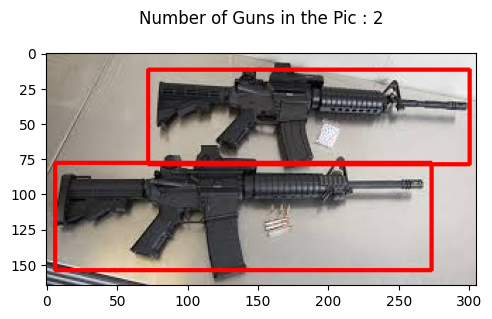

In [63]:
imgshow(119, title="Number of Guns in the Pic : ")

In [64]:
class Gun_data(Dataset):

    def __init__(self,root):
        self.image_path = root+"Images/"
        self.labels_path = root+"Labels/"
        self.img_name = [img for img in sorted(os.listdir(self.image_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

    def __getitem__(self,idx):
        image_path = os.path.join(self.image_path, str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).permute(2,0,1)

        label_name = self.img_name[idx][:-4]+"txt"
        label_path = os.path.join(self.labels_path, str(label_name))

        with open(label_path,"r") as label_file:
            l_count = int(label_file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int,label_file.readline().split())))

        labels =[]
        target = {}
        area = []

        for i in range(len(box)):
            a = ((box[i][2] - box[i][0]) * (box[i][3] - box[i][1]))
            area.append(a)

        for i in range(len(box)):
            labels.append(1)

        target["boxes"] = torch.as_tensor(box)
        target["area"] = torch.as_tensor(area)
        target["image_id"] = torch.as_tensor([idx])
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

        img_res = img_res.to(device)
        for key in target:
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key].to(device)
        return img_res,target

    def __len__(self):
        return len(self.img_name)

In [65]:
class Model:
    def __init__(self,num):
        self.num = num
        self.model = self.create_model()

    def create_model(self):
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num)
        return model
        
    def compiler(self,optimizer):
        self.optimizer = optimizer

    def train(self, train_data, val_data):
        for epoch in tqdm(range(num_epoch)):
            self.model = self.model.to(device)
            train_loss = 0
            self.model.train()

            for img,target in train_data:
                loss_dic = self.model(img, target)
                loss = sum(loss for loss in loss_dic.values())
                
                self.optimizer.zero_grad()
                loss.backward()
                
                self.optimizer.step()
                train_loss += loss
            
            print(f"Epoch : {epoch+1} | Train loss : {train_loss}")

In [66]:
rcnn = Model(2)
model = rcnn.model
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epoch = 30
rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = Gun_data("/kaggle/input/guns-object-detection/")

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size,val_size])
train_loader = DataLoader(train_dataset, batch_size = 3, shuffle=True, num_workers=0, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size = 3, shuffle=False, num_workers=0, collate_fn = collate_fn)


In [67]:
rcnn.train(train_loader, val_loader)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch : 1 | Train loss : 22.569169998168945
Epoch : 2 | Train loss : 17.451698303222656
Epoch : 3 | Train loss : 14.325443267822266
Epoch : 4 | Train loss : 12.595070838928223
Epoch : 5 | Train loss : 10.78955364227295
Epoch : 6 | Train loss : 9.163347244262695
Epoch : 7 | Train loss : 13.2315673828125
Epoch : 8 | Train loss : 9.296860694885254
Epoch : 9 | Train loss : 7.016839981079102
Epoch : 10 | Train loss : 6.208382606506348
Epoch : 11 | Train loss : 5.904052257537842
Epoch : 12 | Train loss : 5.28959321975708
Epoch : 13 | Train loss : 5.439846515655518
Epoch : 14 | Train loss : 5.2897725105285645
Epoch : 15 | Train loss : 5.1883673667907715
Epoch : 16 | Train loss : 4.551350116729736
Epoch : 17 | Train loss : 4.3705830574035645
Epoch : 18 | Train loss : 4.553829669952393
Epoch : 19 | Train loss : 4.177390098571777
Epoch : 20 | Train loss : 3.8517751693725586
Epoch : 21 | Train loss : 3.92535138130188
Epoch : 22 | Train loss : 3.8731770515441895
Epoch : 23 | Train loss : 3.9759590

In [68]:
def test(data, number=random.randint(1,334)):
    img,target =  data[number]
    model.eval()
    predictions = model([img])
    predictions = [{k:v.to(device) for k,v in t.items()} for t in predictions]

    return predictions,target,img

In [69]:
def apply_nms(original_predictions, iou_threshold=None):
    keep = torchvision.ops.nms(original_predictions["boxes"], original_predictions["scores"], iou_threshold)
    final_predictions = original_predictions
    final_predictions["boxes"] = final_predictions["boxes"][keep]
    final_predictions["scores"] = final_predictions["scores"][keep]
    final_predictions["labels"] = final_predictions["labels"][keep]
    return final_predictions

In [70]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [72]:
def plot_img_bbox(img,target,size=5):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for box in target["boxes"]:
        x,y,width,height = box.tolist()
        cv2.rectangle(img_cv, (int(x), int(y)), (int(x+width), int(y+height)), (0,0,255), 2)

    aspect_ratio = img_cv.shape[0]/img_cv.shape[1]
    plt.figure(figsize=(size+aspect_ratio, size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.show

In [73]:
predictions, target, img = test(dataset, number=10)

In [74]:
predictions

[{'boxes': tensor([[ 15.6961,   7.8635,  68.9877,  55.8433],
          [126.2750,  25.9414, 149.7011,  57.2797]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9996, 0.9991], device='cuda:0', grad_fn=<IndexBackward0>)}]

In [75]:
target

{'boxes': tensor([[ 16,   9,  68,  56],
         [127,  26, 149,  58]], device='cuda:0'),
 'area': tensor([2444,  704], device='cuda:0'),
 'image_id': tensor([10], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0')}

In [76]:
img

tensor([[[0.9647, 0.9725, 0.9843,  ..., 0.6824, 0.6902, 0.7020],
         [0.9804, 0.9882, 1.0000,  ..., 0.6549, 0.6392, 0.6314],
         [0.9490, 0.9569, 0.9686,  ..., 0.6392, 0.6118, 0.5961],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0863, 0.0706, 0.0353],
         [0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0078, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.9294, 0.9373, 0.9490,  ..., 0.6157, 0.6235, 0.6431],
         [0.9451, 0.9529, 0.9686,  ..., 0.5882, 0.5725, 0.5725],
         [0.9137, 0.9216, 0.9333,  ..., 0.5725, 0.5451, 0.5373],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0863, 0.0706, 0.0353],
         [0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0078, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.8941, 0.9020, 0.9137,  ..., 0.5451, 0.5451, 0.5608],
         [0.9098, 0.9176, 0.9333,  ..., 0.5176, 0.4941, 0.4902],
         [0.8784, 0.8863, 0.8980,  ..., 0.5020, 0.4667, 0.

In [77]:
nms_prediction = apply_nms(predictions[0], iou_threshold=0.7)

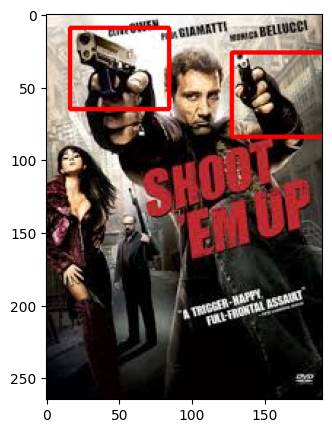

In [81]:

plot_img_bbox(torch_to_pil(img),target)

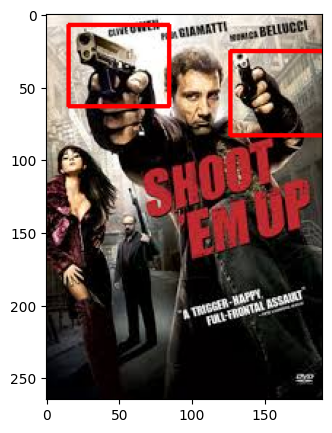

In [83]:

plot_img_bbox(torch_to_pil(img),nms_prediction)